# HW1: VAEs

This is a clone of the vae.ipynb notebook found at https://avandekleut.github.io/vae/

In [1]:
# Load this if you are editing libraries while running the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from PIL import Image, ImageOps
import os, sys
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import random

random_state = 69
torch.manual_seed(random_state)
np.random.seed(random_state)
random.seed(random_state)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

dims = 64
latent_dims = 2
# path = "./data/lego-blender-64x64-1/"
# path = "./data/lego-blender-3/"
# path = "./data/lego-blender-3-special/"
# path = "./data/lego-blender-4/"
# path = "./data/lego-3/"
path = "./data/lego-dataset/"
lego_dir = path.split("/")
if lego_dir[-1] == "":
    lego_dir = lego_dir[:-1] 
lego_dir[-1] = lego_dir[-1] + "_" + str(dims)
lego_dir = "/".join(lego_dir) + "/"

cuda


In [4]:
dirs = os.listdir( path )

def resize_and_augment():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((dims,dims), Image.ANTIALIAS).convert("L")
            os.makedirs(lego_dir, exist_ok=True)
            imResize.save(lego_dir + item, 'JPEG', quality=90)
            im_mirror = ImageOps.mirror(imResize).convert("L")
            im_mirror.save(lego_dir + "mirror_" + item, 'JPEG', quality=90)

resize_and_augment() 

C:\Users\Tyler Chan\AppData\Local\Temp\ipykernel_74876\1782986600.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imResize = im.resize((dims,dims), Image.ANTIALIAS).convert("L")


In [5]:
def create_annotations(data_dir):
    pandas_data = []
    if os.path.exists(data_dir):
        l = os.listdir(data_dir)
        for i in range(len(l)):
            pandas_data.append((l[i], 0))
    return pd.DataFrame(pandas_data)

class LegoDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

dataset = LegoDataset(create_annotations(lego_dir), lego_dir, transform=torchvision.transforms.ConvertImageDtype(torch.float32))
data = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=True)


In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, dims**2)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, dims, dims))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(dims**2, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

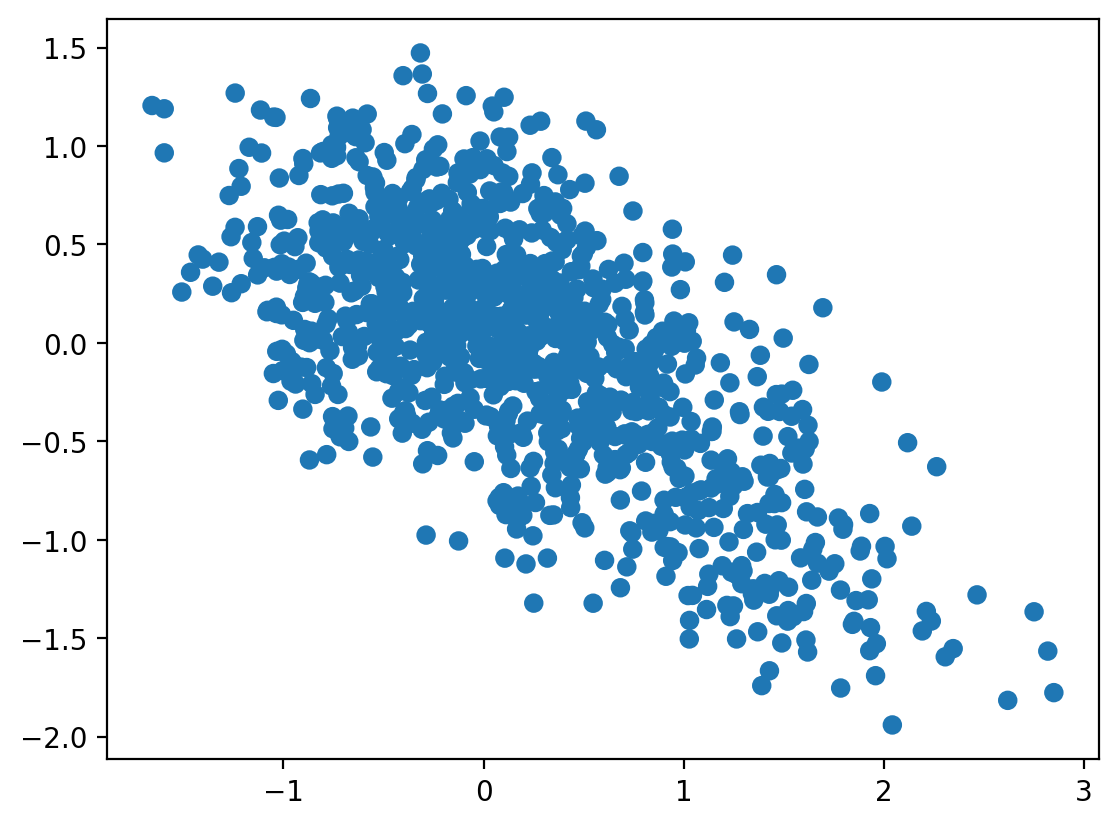

In [7]:
def plot_latent(autoencoder, data, num_batches=100):
    if latent_dims != 2:
        print("Latent dims must be 2")
        return
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(vae, data)

./data/lego-dataset/
dims: 64
latent_dims: 2


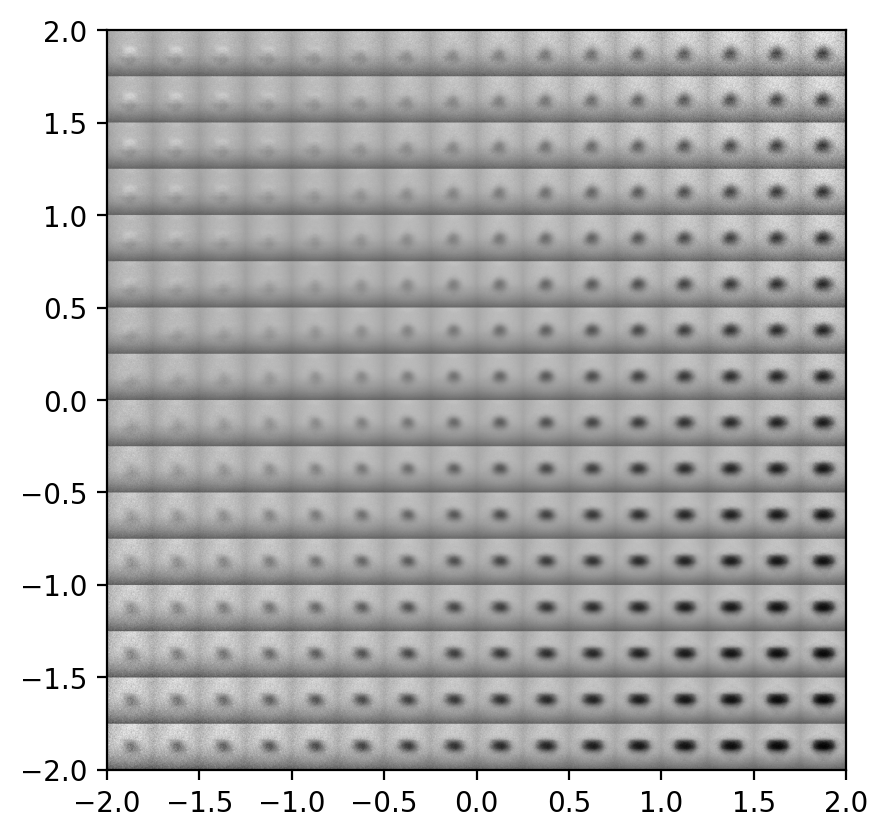

In [8]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    if latent_dims != 2:
        print("Latent dims must be 2")
        return
    w = dims 
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(dims, dims).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gray')

x, y = 2,2
plot_reconstructed(vae, r0=(-x, x), r1=(-y, y), n=16)
print(path)
print(f"dims: {dims}")
print(f"latent_dims: {latent_dims}")

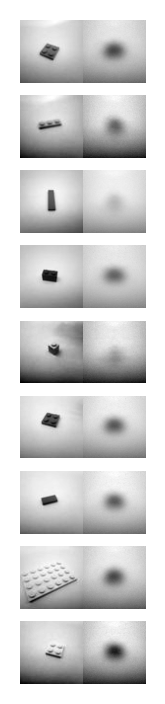

In [9]:
num_images = 10
for i, (x, y) in enumerate(data):
  if i == num_images:
    break
  x = x[0].to(device)
  latent_image = vae.encoder(x)
  x_hat = vae.decoder(latent_image)

  plt.subplot(num_images, 1, i+1)
  x_img = x.to("cpu").detach().numpy().reshape(dims, dims)
  x_hat_img = x_hat.to("cpu").detach().numpy().reshape(dims, dims)
  combined = np.hstack((x_img, x_hat_img))
  plt.imshow(combined, cmap='gray')
  plt.axis("off")
plt.show()

In [10]:
def encode_and_interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    interpolate(autoencoder, z_1, z_2, n=n)

def interpolate(autoencoder, z_1, z_2, n=12):
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = dims
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(dims, dims)
    plt.imshow(img, cmap="gray")
    plt.xticks([])
    plt.yticks([])

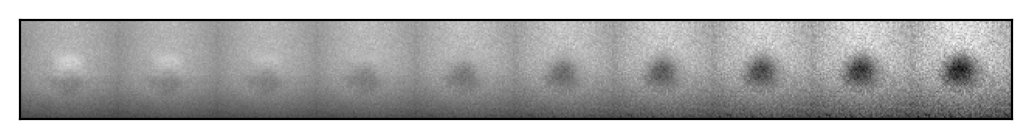

In [11]:
# for x, y in data:
#   x_1 = x[0].to(device)
#   x_2 = x[1].to(device)
#   break

z_1 = torch.Tensor([[-2, 2]]).to(device)
z_2 = torch.Tensor([[2, 2]]).to(device)

interpolate(vae, z_1, z_2, n=10)

In [12]:
def encode_and_interpolate_gif(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    interpolate_gif(autoencoder, z_1, z_2, n=n)

def interpolate_gif(autoencoder, filename, z_1, z_2, n=100):
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(dims, dims)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)

In [13]:
interpolate_gif(vae, "vae-lego", z_1, z_2, n=10)